# Imports

In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt
import os

from keras.initializers import glorot_uniform

#from modules import lib
#from modules import plots
#from modules import models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp "/content/drive/MyDrive/CVDL/modules/lib.py" .
import lib

!cp "/content/drive/MyDrive/CVDL/modules/plots.py" .
import plots

# Parameters

In [5]:
seed = 42

# dataset images res: 606x468px -> 1.2948
# og: input_res = (224, 160)
input_res = (224, 160)

params = {
          'x':input_res[0],                                
          'y':input_res[1],                                
          'batch_size': 12,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          #'learningRate': 1e-5,  # 0.0067
          #'learningRate': 1e-4,  # 0.018
          'learningRate': 8e-4,                       
          'momentum': 0.98,                        
          'nEpoches': 50,                        
          }


root_path = "/content/drive/MyDrive/CVDL/"
dumps_path = root_path + "dumps/"

# 70% training set, 20% test set, 10% val set
ratio_test = 0.7
ratio_val  = 0.9

#lib.create_dump([params, seed], dumps_path + "params")

#dataset  = "./Dataset" 
dataset  = root_path + "dataset" 
type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

# get name of file imgs
imgs_list_path = os.listdir(path_img)

# Data loading & preprocessing

In [ ]:
# LOAD & SPLIT DATA ============================================================
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, dumps_path + "splitted_data")

#Loading Data from Pickle

In [6]:
#dataset_list = pickle.load(open( dumps_path + "splitted_data_384x288", "rb" ))
dataset_list = pickle.load(open( dumps_path + "splitted_data_224x160", "rb" ))

# Data Augmentation

In [7]:
# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

print(params["length_training"])
print(params["length_validation"])

165
25


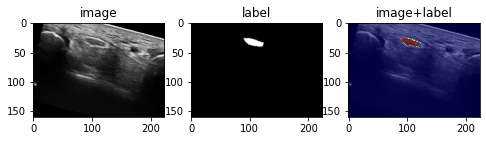

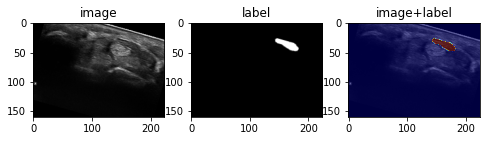

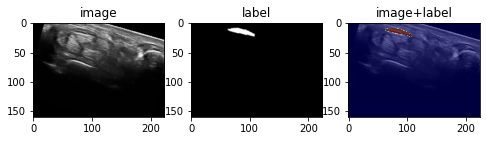

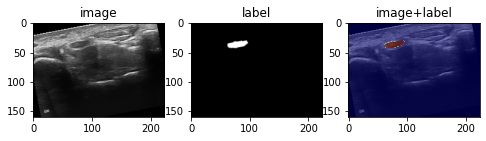

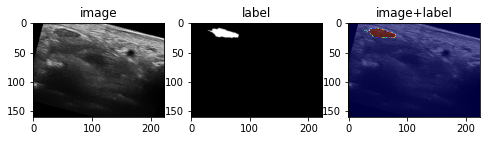

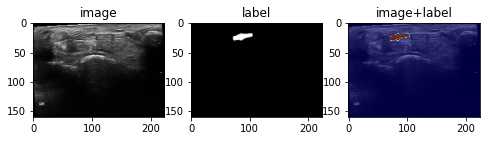

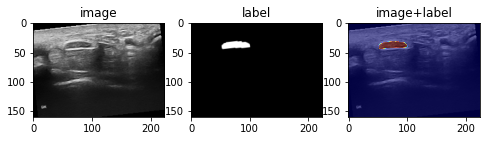

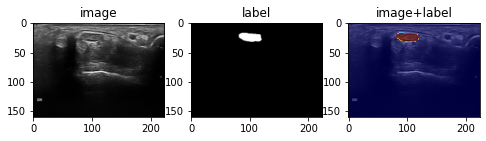

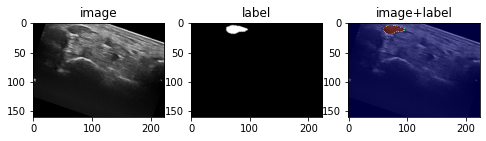

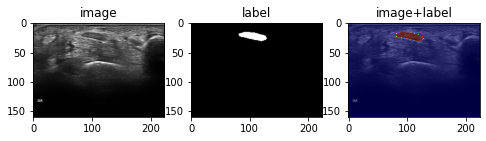

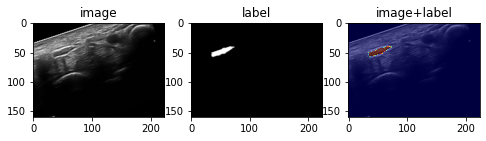

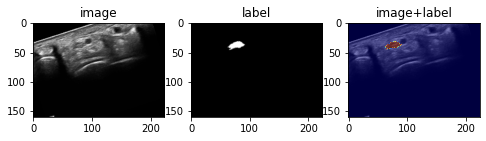

In [8]:
augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

# Model definition & training

In [9]:
!cp "/content/drive/MyDrive/CVDL/modules/models/lightweight_unet.py" .
import lightweight_unet

In [10]:
initializer = glorot_uniform()
input_size = (input_res[1], input_res[0], 1)

model = lightweight_unet.lw_unet(initializer, input_size)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 160, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
import pickle
import numpy as np
import os
import cv2
import copy
import glob
import json
import random

import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras import backend as k
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K

from itertools import groupby
from itertools import chain

In [12]:
from tensorflow.keras.losses import binary_crossentropy

#map function
def clamp(n):
    if n < 0: return 0.0
    elif n > 1: return 1.0
    else: return n

# Dice Coefficient
# source: https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
def dice(output, target, loss_type='sorensen', axis=(1, 2, 3), smooth=1e-7):
  inse = tf.reduce_sum(output * target, axis=axis)
  
  if loss_type == 'jaccard':
      l = tf.reduce_sum(output * output, axis=axis)
      r = tf.reduce_sum(target * target, axis=axis)
  elif loss_type == 'sorensen':
      l = tf.reduce_sum(output, axis=axis)
      r = tf.reduce_sum(target, axis=axis)
  else:
      raise Exception("Unknow loss_type")

  dice = (2. * inse + smooth) / (l + r + smooth)
  #dice = clamp(tf.reduce_mean(dice, name='dice'))
  dice = tf.reduce_mean(dice, name='dice')
  
  return dice

# IoU Coefficient
# source: https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
def iou(output, target, threshold=0.5, axis=(1, 2, 3), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the
    similarity of two batch of data, usually be used for evaluating binary image segmentation.
    The coefficient between 0 to 1, and 1 means totally match.
    
    Notes
    ------
    - IoU cannot be used as training loss, people usually use dice coefficient for training, 
      IoU and hard-dice for evaluating.
    """
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
    
    batch_iou = (inse + smooth) / (union + smooth)
    iou = clamp(tf.reduce_mean(batch_iou, name='iou'))
    
    return iou  # , pre, truth, inse, union

# Dice Loss
def dice_loss(output, target):
  return 1. - dice(output, target)

# BCE-Dice Loss
# source: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch#BCE-Dice-Loss
def bce_dice_loss(output, target):
    return binary_crossentropy(output, target) + dice_loss(output, target)

In [ ]:
root = root_path + "dataset/results/weights/lw_unet" 

loss      = bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

metrics   = [dice, iou, recall, precision]

train_history, model = lib.train(root, params, model, loss, metrics, train_generator, val_generator)

In [27]:
import pandas as pd
history_df = pd.DataFrame(train_history.history)
history_df

,loss,dice,iou,recall,precision,val_loss,val_dice,val_iou,val_recall,val_precision
0,1.207651,0.053948,0.080116,0.228054,0.045654,1.665048,0.017375,3.477262e-08,0.000000,0.000000
1,0.919543,0.158949,0.250398,0.472485,0.305939,1.300253,0.012076,3.486101e-08,0.000000,0.000000
2,0.616633,0.421679,0.435740,0.674844,0.532852,1.165787,0.037344,5.695048e-02,0.397920,0.076365
3,0.471747,0.561392,0.478357,0.612166,0.626762,1.064911,0.015524,3.943562e-08,0.000000,0.000000
4,0.399245,0.632357,0.530035,0.619898,0.694729,1.043251,0.014404,3.895056e-08,0.000000,0.000000
5,0.336177,0.687523,0.589596,0.668807,0.733724,1.043646,0.008087,3.868329e-08,0.000000,0.000000
6,0.320750,0.705223,0.599987,0.680686,0.729145,1.048326,0.006033,3.312444e-08,0.000000,0.000000
7,0.296672,0.726141,0.629252,0.695829,0.779271,1.054130,0.003738,3.109456e-08,0.000000,0.000000
8,0.338979,0.688549,0.591263,0.667005,0.740966,1.058423,0.002513,3.223960e-08,0.000000,0.000000
9,0.290104,0.732912,0.634713,0.704662,0.788237,1.060820,0.001972,3.762913e-08,0.000000,0.000000


In [14]:
model.load_weights("/content/drive/MyDrive/CVDL/dataset/results/weights/lw_unet/Model038-0.185572.hdf5")

In [15]:
train_figure = plots.plot_train_metric(train_history, params['nEpoches'], "dice")

plt.show()

NameError: ignored

# Examinate *Rsults*

In [16]:
# Examine results
import pandas as pd

# Set the threshold for predictions
threshold = 0.5

# Select the image on which make 
results = {}
length_test = len(dataset_list[0]['test'])

for image_index in range (length_test):
    test_image = cv2.resize(dataset_list[0]['test'][image_index,:,:,0],(params["x"],params["y"]))
    test_mask = cv2.resize(dataset_list[1]['test'][image_index,:,:,0],(params["x"],params["y"]))
    test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)
    results[image_index] = {'dice': lib.dice(test_mask, test_results["pred_mask"])}
results

{0: {'dice': 0.7506493506493507},
 1: {'dice': 0.9398663697104677},
 2: {'dice': 0.9330499468650372},
 3: {'dice': 0.9120171673819742},
 4: {'dice': 0.7514944491887275},
 5: {'dice': 0.7554179566563467},
 6: {'dice': 0.5397923875432526},
 7: {'dice': 0.0},
 8: {'dice': 0.0026490066225165563},
 9: {'dice': 0.1005586592178771},
 10: {'dice': 0.4609375},
 11: {'dice': 0.8590163934426229},
 12: {'dice': 0.0},
 13: {'dice': 0.0},
 14: {'dice': 0.413953488372093},
 15: {'dice': 0.881559220389805},
 16: {'dice': 0.4935064935064935},
 17: {'dice': 0.7315436241610739},
 18: {'dice': 0.8776595744680851},
 19: {'dice': 0.7046153846153846},
 20: {'dice': 0.0},
 21: {'dice': 0.5378973105134475},
 22: {'dice': 0.9034090909090909},
 23: {'dice': 0.8855869242199108},
 24: {'dice': 0.9001956947162426},
 25: {'dice': 0.61},
 26: {'dice': 0.8688524590163934},
 27: {'dice': 0.5133689839572193},
 28: {'dice': 0.8631578947368421},
 29: {'dice': 0.0},
 30: {'dice': 0.0462046204620462},
 31: {'dice': 0.856680

In [17]:
results_df = pd.DataFrame(results).transpose()
print(results_df['dice'].mean())

0.5081170952131728


In [22]:
res = results_df.loc[(results_df['dice'] < 0.60)]
print(res)

num = res['dice'].count()
den = results_df['dice'].count()

print(num/den)

        dice
7   0.184211
8   0.353045
10  0.526923
12  0.469626
13  0.467662
30  0.375235
36  0.590690
38  0.421171
39  0.037951
41  0.566038
42  0.213235
44  0.473037
45  0.471204
46  0.158879
48  0.082372
49  0.354651
51  0.117647
0.30357142857142855


# Testing results

testing accuracy: 0.9952566964285714
testing dice: 0.096


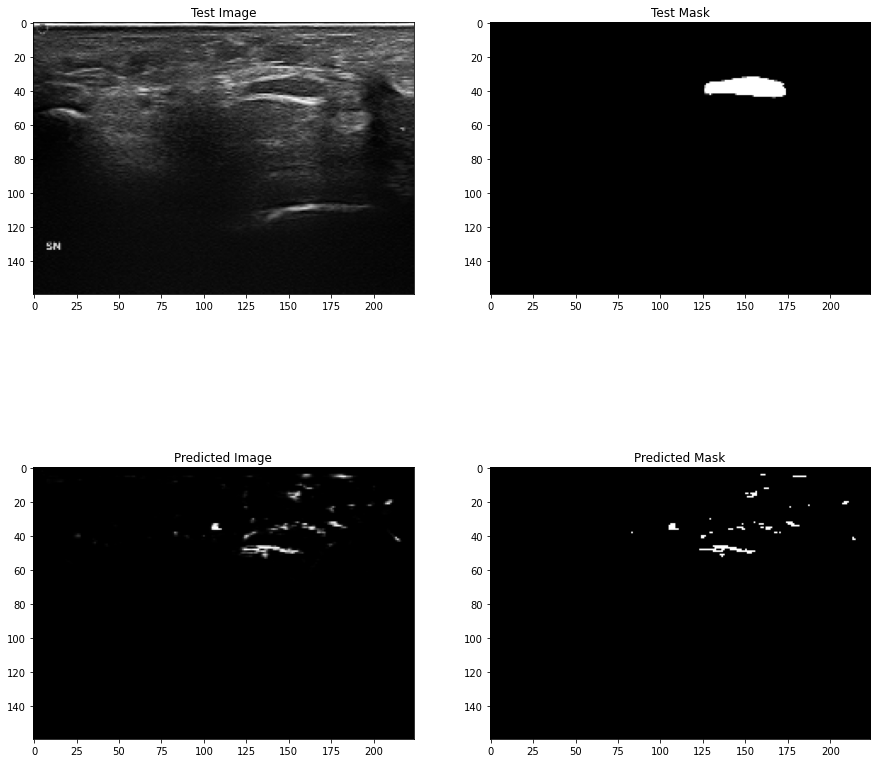

In [24]:
# Examine results

# Set the threshold for predictions
threshold = 0.45
# Select the image on which make 
image_index = 48
test_image = cv2.resize(dataset_list[0]['test'][image_index,:,:,0],(params["x"],params["y"]))
test_mask = cv2.resize(dataset_list[1]['test'][image_index,:,:,0],(params["x"],params["y"]))

test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)

print("testing accuracy:", lib.accuracy(test_mask, test_results["pred_mask"]))
print("testing dice:", lib.dice(test_mask, test_results["pred_mask"]))

results_figure = plots.plot_test_results(test_results)
plt.show()
